Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Distributed Image Classification with PyTorch

In this tutorial, you will train a PyTorch model on the [CIFAR10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset using distributed training with PyTorch's `DistributedDataParallel` module across a AKS-HCI CPU cluster. The training dataset are stored on the on-premise NFS Server.

## Prerequisites

* [Setup Azure Arc-enabled Machine Learning Training and Inferencing on AKS on Azure Stack HCI](https://github.com/Azure/AML-Kubernetes/tree/master/docs/AKS-HCI/AML-ARC-Compute.md)

* [Setup NFS Server on Azure Stack HCI and Use your Data and run managed Machine Learning Experiments On-Premises](https://github.com/Azure/AML-Kubernetes/tree/master/docs/AKS-HCI/Train-AzureArc.md)

* Make sure the NFS Server is mounted on the notebook execution machine. In this notebook, it will upload the training data to NFS Server.

* Last but not least, you need to be able to run a Notebook. (azureml-core, azureml-opendatasets, numpy, matplotlib, requests are required)

   If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure you go through the configuration Notebook located at [here](https://github.com/Azure/MachineLearningNotebooks) first. This sets you up with a working config file that has information on your workspace, subscription id, etc.

In [ ]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

## Initialize AzureML workspace

Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`. 

If you haven't done already please go to `config.json` file and fill in your workspace information.

In [ ]:
from azureml.core.workspace import Workspace,  ComputeTarget
from azureml.exceptions import ComputeTargetException

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

## Download cifar10 data

Use this function to download cifar10 data later. This function allows you to avoid download the data again when you run this notebook multiple times. The actual download time may take 5 minutes.

In [ ]:
import os
import requests
import tempfile

def download_cifar10_data():
    
    path = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    downloaded_folder = os.path.join(os.getcwd(), 'cifar10-data')
    os.makedirs(downloaded_folder, exist_ok=True) # download data to 'cifar10-data' folder

    data = requests.get(path, allow_redirects=True).content
    with open(os.path.join(downloaded_folder, path.split('/')[-1]), 'wb') as f:
        f.write(data)
        
    return downloaded_folder

downloaded_folder = download_cifar10_data()
downloaded_folder

## Prepare the cifar10 data to NFS server (Optional)

The above download_cifar10_data() function will download cifar-10-python.tar.gz to downloaded_folder.  Your next step is to copy these files to NFS server.
Run run this step, you need to make sure the NFS path is mounted on the notebook execution machine. Replace `<NFS Mount Point on notebook execution machine>` with the correct path.

This step is optional, you can use other ways, such as directly downloading training data on NFS server to prepare the cifar10 data.

In [ ]:
nfs_mount_path = "<NFS Mount Point on notebook execution machine>"

import os, shutil
cifar10_dir = os.path.join(nfs_mount_path, 'cifar10')
shutil.rmtree(cifar10_dir, ignore_errors=True)
os.makedirs(cifar10_dir, exist_ok=True)

for filename in os.listdir(downloaded_folder):
    filepath = os.path.join(downloaded_folder, filename)
    destpath = os.path.join(cifar10_dir, filename)
    print(f"Copying files from {filepath} to {destpath}")
    shutil.copyfile(filepath, destpath)

## Setup compute target

Find the attach name for the Arc enabled AKS-HCI in your AzureML workspace.

attach_name is the attached name for your ASH cluster you setup in [this step](https://github.com/Azure/AML-Kubernetes/tree/master/docs/AKS-HCI/AML-ARC-Compute.md#attach-your-azure-arc-enabled-cluster-to-your-azure-machine-learning-workspace-as-a-compute-target)

In [ ]:
from azureml.core.compute import KubernetesCompute

# attach_name = "arc-compute2"
attach_name = "aksarc-compute"
arcK_target = KubernetesCompute(ws, attach_name)
print("using compute target: ", arcK_target.name)
print(f"compute target id in endpoint yaml: azureml:{arcK_target.name}, instance type name in endpoint yaml: {arcK_target.default_instance_type}")

## Configure the training job and submit

### Create an experiement

In [ ]:
from azureml.core import Experiment

experiment_name = 'pytorch-cifar-distr'
experiment = Experiment(ws, name=experiment_name)

### Create an environment

In [ ]:
from azureml.core import Environment
from azureml.core.runconfig import DockerConfiguration

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-cpu', file_path = 'pytorch-script/conda_dependencies.yml')

# Specify a CPU base image
pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04'
docker_config = DockerConfiguration(use_docker=True)

### Configure the training job: torch.distributed with GLOO backend

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on.

In order to run a distributed PyTorch job with **torch.distributed** using the GLOO backend, create a `PyTorchConfiguration` and pass it to the `distributed_job_config` parameter of the ScriptRunConfig constructor. Specify `communication_backend='Gloo'` in the PyTorchConfiguration. The below code will configure node_count = 2. These is the number of worker nodes. The number of  distributed jobs will be 3 if one master node is used.  GLOO backend which is recommended backend for communications between CPUs.

Tthe script for distributed training of CIFAR10 is already provided for you at `pytorch-script/cifar_dist_main.py`. In practice, you should be able to take any custom PyTorch training script as is and run it with Azure ML without having to modify your code.

In [ ]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import PyTorchConfiguration
from azureml.core import Dataset
import os

data_folder = "/nfs_share" + "/cifar10"
args = [
        '--data-folder', data_folder,
        '--dist-backend', 'gloo',
       '--epochs', 1 #20
           ]

distributed_job_config=PyTorchConfiguration(communication_backend='Gloo', node_count=2) #configuring AML pytorch config

project_folder = "pytorch-script"
run_script = "cifar_dist_main.py"
src = ScriptRunConfig(
                     source_directory=project_folder,
                      script=run_script,
                      arguments=args,
                      compute_target=arcK_target,
                      environment=pytorch_env,
                      distributed_job_config=distributed_job_config,
                      docker_runtime_config=docker_config)

### Submit the job
Run your experiment by submitting your ScriptRunConfig object. Note that this call is asynchronous.

In [ ]:
run = experiment.submit(src)
run.wait_for_completion(show_output=True) # this provides a verbose log

### Register the model

Register the trained model.

In [ ]:
register_model_name = 'cifar10torch'
model = run.register_model(model_name=register_model_name, model_path='outputs/cifar10torch.pt')

The machine learning model named "cifar10torch" should be registered in your AzureML workspace.

### Get the model

In [ ]:
from azureml.core.model import Model
model = Model(ws, register_model_name)
model_id = f"azureml:{model.name}:{model.version}"
print(f"Get {model.name}, latest version {model.version}, id in endpoint.yml: {model_id}")

## Deploy and score a machine learning model by using a managed online endpoint

Currently, amlarc inference is only supported with Azure Machine Learning CI (v2). Please follow [doc](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-cli?view=azure-devops#prerequisites) to configure the prerequisites. This notebook will invoke Azure Machine Learning CI (v2) directly.

In [ ]:
# endpoint = '<cifar10torch endpoint name>'
endpoint = 'cifar10torch-jiadu'

import os
from pathlib import Path
prefix = Path(os.getcwd())
endpoint_file = str(prefix.joinpath("pytorch_endpoint.yml"))
print(f"Using Endpoint file: {endpoint_file}, please replace <modelId> (e.g. azureml:cifar10torch:1), <instanceTypeName> (e.g. defaultInstanceType) and <computeTargetName> (e.g. azureml:amlarc-compute) according above output")

Need to **replace the properties in endpoint.yml**, including,
* `<modelId>`: example value: azureml:sklearn_mnist:1
* `<instanceTypeName>`: example value: defaultInstanceType
* `<computeTargetName>`: example value: azureml:amlarc-compute

In [ ]:
import helpers
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')
helpers.run(f"az ml endpoint create -n {endpoint} -f {endpoint_file} -w {ws.name} -g {ws.resource_group}")

Get score_uri and access_token from AZ CLI (Currently only Azure Machine Learning CLI (v2) supported)

In [ ]:
# get score_url and access_token from AZ CLI
import helpers
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
cmd = f"az ml endpoint show -n {endpoint} -w {ws.name} -g {ws.resource_group}"
properties = helpers.run(cmd, return_output=True, no_output=True)

cmd = f"az ml endpoint get-credentials -n {endpoint} -w {ws.name} -g {ws.resource_group}"
credentials = helpers.run(cmd, return_output=True, no_output=True)

print(f"Got endpoint and credentials.")

### Test with inputs

For testing purpose, first image (a cat) from test batch is extracted (it is saved at test_imgs/test_img_0_cat.jpg). It is shown here: 

![fishy](test_imgs/test_img_0_cat.jpg)

After some data process, the image converted to json as input for the trained model. The outputs are logits for each class per image:

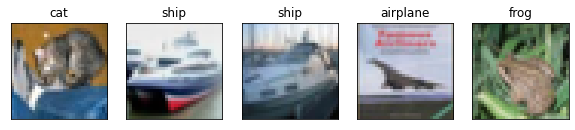

In [176]:
import os
import glob
import tarfile
import matplotlib.pyplot as plt
import numpy as np

data_folder = os.path.join(os.getcwd(), 'cifar10-data')
extracted_folder = os.path.join(data_folder, "extracted")
os.makedirs(extracted_folder, exist_ok=True)

cifar_gz = glob.glob(os.path.join(data_folder,"**/cifar-10-python.tar.gz"), recursive=True)[0]

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

with tarfile.open(cifar_gz, "r:gz") as tar:
    tar.extractall(path=extracted_folder)
    tar.close()

train_batches = glob.glob(os.path.join(extracted_folder, "**/data_batch_*"), recursive=True)
test_batch = glob.glob(os.path.join(extracted_folder, "**/test_batch*"), recursive=True)[0]
meta_file = glob.glob(os.path.join(extracted_folder, "**/batches.meta"), recursive=True)[0]

# data_batch = unpickle(train_batches[0])
data_batch = unpickle(test_batch)
meta_data = unpickle(meta_file)

# take the images data from batch data
images = data_batch['data']
# reshape and transpose the images
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
# take labels of the images 
labels = data_batch['labels']
# label names of the images
label_names = meta_data['label_names']

# dispaly random images
# define row and column of figure
rows, columns = 1, 5
# take random image idex id
# imageId = np.random.randint(0, len(images), rows * columns)
imageId = np.arange(0, rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()

In [180]:
import json
prop_response = json.loads(properties.replace(os.linesep,""))
score_uri = prop_response["scoring_uri"]

cred_response = json.loads(credentials.replace(os.linesep, ""))
access_token = cred_response["accessToken"]

with open("cifar_test_input_pytorch.json", "r") as fp:
    inputs_json = json.load(fp)
    
inputs = json.dumps(inputs_json)

headers = {'Content-Type': 'application/json', 'Authorization': f"Bearer {access_token}"}
r = requests.post(score_uri, data=inputs, headers=headers)
# print(f"predictions: {r.content}")
predicts = r.json()["predicts"]

predict_labels = parse_predicts(predicts)
print(predict_labels)

['frog', 'car', 'ship', 'ship', 'bird']


In [193]:
import json
prop_response = json.loads(properties.replace(os.linesep,""))
score_uri = prop_response["scoring_uri"]

cred_response = json.loads(credentials.replace(os.linesep, ""))
access_token = cred_response["accessToken"]

import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_set = datasets.CIFAR10(root=extracted_folder, train=False, download=False, transform=transform_test)

def parse_predicts(predicts):
    import numpy as np
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')
    np_predicts = np.array(predicts)
    pred_indexes = np.argmax(np_predicts, 1)

    predict_labels = [classes[i] for i in pred_indexes]
    return predict_labels

import requests
total = 0
match = 0
testImgs=[]
testClasses=[]
for i in range(0, rows * columns):
    img, target = test_set[i]
    testImage = img.numpy()
    testImg = testImage.reshape(1, 3, 32, 32)
    testClass = test_set.classes[target]
    testClasses.append(testClass)
    testImgs.append(testImg.reshape(3, 32, 32).tolist())
    total = total + 1

request_body = {"instances": testImgs}
with open(os.path.join("test_request_pytorch", f"cifar_test_input_img_first_{total}_pytorch.json"), 'w', encoding='utf-8') as f:
    json.dump(request_body, f, ensure_ascii=False, indent=4)

inputs = json.dumps(request_body)

headers = {'Content-Type': 'application/json', 'Authorization': f"Bearer {access_token}"}
r = requests.post(score_uri, data=inputs, headers=headers)
# print(f"predictions: {r.content}")
predicts = r.json()["predicts"]

predict_labels = parse_predicts(predicts)

for i in range(0, rows * columns):
    test_label = testClasses[i]
    predict_label = predict_labels[i]
    if test_label == predict_label:
        match = match + 1
    print(f"Image {i}, tag_label: {test_label}, predict_label: {predict_label}")

acc = match / total / 1.0
print(f"Tested {total} images, accuracy: {acc}")

Image 0, tag_label: cat, predict_label: frog
Image 1, tag_label: ship, predict_label: car
Image 2, tag_label: ship, predict_label: ship
Image 3, tag_label: airplane, predict_label: ship
Image 4, tag_label: frog, predict_label: bird
Tested 5 images, accuracy: 0.2


In [179]:
import json
prop_response = json.loads(properties.replace(os.linesep,""))
score_uri = prop_response["scoring_uri"]

cred_response = json.loads(credentials.replace(os.linesep, ""))
access_token = cred_response["accessToken"]

import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_set = datasets.CIFAR10(root=extracted_folder, train=False, download=False, transform=transform_test)

def parse_predicts(predicts):
    import numpy as np
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')
    np_predicts = np.array(predicts)
    pred_indexes = np.argmax(np_predicts, 1)

    predict_labels = [classes[i] for i in pred_indexes]
    return predict_labels

import requests
total = 0
match = 0
for i in range(0, rows * columns):
    img, target = test_set[i]
    testImage = img.numpy()
    testImg = testImage.reshape(1, 3, 32, 32)
    testClass = test_set.classes[target]
    
    request_body = {"instances": testImg.tolist()}
    with open(os.path.join("test_request_pytorch", f"cifar_test_input_img_{i}_{testClass}_pytorch.json"), 'w', encoding='utf-8') as f:
        json.dump(request_body, f, ensure_ascii=False, indent=4)
    inputs = json.dumps(request_body)
    headers = {'Content-Type': 'application/json', 'Authorization': f"Bearer {access_token}"}
    r = requests.post(score_uri, data=inputs, headers=headers)
    # print(f"predictions: {r.content}")
    predicts = r.json()["predicts"]

    predict_labels = parse_predicts(predicts)

    if testClass in predict_labels:
        match = match + 1

    total = total + 1
    print(f"Image {i}, tag_label: {testClass}, predict_label: {predict_labels[0]}")

acc = match / total / 1.0
print(f"Tested {total} images, accuracy: {acc}")

Image 0, tag_label: cat, predict_label: frog
Image 1, tag_label: ship, predict_label: car
Image 2, tag_label: ship, predict_label: ship
Image 3, tag_label: airplane, predict_label: ship
Image 4, tag_label: frog, predict_label: bird
Tested 5 images, accuracy: 0.2


Then you can easily get the predictions of labels:

Depending on your model, you may or may not get the correct label which is "cat".